# Arrival time picking example

This notebook shows the different steps of the arrival time picking algorithm. The script is based on cross correlations of channels with a good Signal-to-Noise-Ratio (SNR), and interpolation in between those channels.
The picks are iteratively improved by taking a smart time window around the picks and repeating the process.

We use one event as an example, it is an event that is measured at many channels, but the amplitudes are not very high. This event would be very challenging to pick with other algorithms, or even manually. The result is not perfect, but we optimize the algorithm

In [19]:
import glob, os
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

from scipy import interpolate
from scipy.ndimage.filters import gaussian_filter1d
import scipy.signal as ss

from obspy.signal.cross_correlation import correlate, xcorr_max
from obspy.core import UTCDateTime



## Parameters

These are all the parameters that are used in the algorithm. Changing any of them can have significant impacts on the results, they need to be finetuned for specific experiments.

In [2]:
# lenth of noise window (s)
noise_window_len = 2
# amplitude above which to clean data
clean_amplitude = 2000
# average frequency threshold above which to clean data
clean_threshold = 1e4
# fraction to taper for standard processing
taper_fraction = 0.05
# lower frequency bandpass filter
freq_min = 2
# higher frequency bandpass filter
freq_max = 20
# first SNR threshold with channels to include in picking
snr_threshold1 = 1.5
# second SNR threshold
snr_threshold2 = 1.1
# exclude picks with this many channels in between them (fraction of channels)
interpolate_jump_fraction = 0.3
# exclude picks with this many channels in between them (number of channels)
interpolate_jump_minimum = 50
# exclude channels with jumps this close to edge (fraction of channels)
jump_edge = 0.1
# interpolate factor in cross correlation function
interpolate_factor = 10
# minimum velocity to determine allowed shift between channels
minimum_velocity = 600
# threshold at which to stop 2d correlation (fraction)
shift_threshold_fraction1 = 0.5
# threshold at which to stop 2d correlation (fraction)
shift_threshold_fraction2 = 0.7
# number of iterations to improve picks
iterations = 3
# center window around picks (1/window_fraction before picks, rest after)
window_fraction = 2
# smooth the window
window_smoothing = 50
# decrease window size per iteration (factor)
decrease_window_product = 3
# decrease window size per iteration (number)
decrease_window_sum = 3

channel = np.arange(45,1539)
startchannel = 25
endchannel = 1289
fs = 200

## Functions

These are the functions we use in the algorithm.

In [3]:
def clean_data(data, clean_amplitude, clean_threshold):
    """
    function to clean data, empirically found to work well for the Grímsvötn events. 
    If a channel is above a certain amplitude in the time domain, and it's spectrum is above a certain average, then the channel is removed and replaced by an average of neighbouring traces.
    
    data: numpy array of data
    clean_amplitude: value above which amplitude in nanostrain rate to clean the data
    clean_threshold: value above which average in the spectrum to clean the data
    """
    tmax = np.zeros(len(data))
    # determine max amplitude per channel
    for i in range(len(data)):
        tmax[i] = np.max(np.abs(data[i]))

    idx = np.where(tmax > clean_amplitude)[0]
    id_del = []

    nt = data.shape[1]
    dt = 1.0/float(fs)
    freq = np.linspace(-0.5/dt,0.5/dt,nt)

    idx1=int(np.where(np.min(np.abs(freq-1.0))==np.abs(freq-1.0))[0][0])
    idx2=int(np.where(np.min(np.abs(freq-10.0))==np.abs(freq-10.0))[0][0])
    
    # determine average spectrum of channels with amplitudes above threshold
    for c, i in enumerate(idx):
        df = np.abs(np.fft.fft(data[i]))
        df=np.roll(df,int((data.shape[1]-1)/2))

        if np.mean(df[idx1:idx2]) < clean_threshold:
            id_del.append(c)

    if len(id_del) > 0:
        idx = np.delete(idx, np.array(id_del))
    
    # replace traces with high amplitudes in time/frequency domain with average of neighbours
    for c, i in enumerate(idx):
        id1 = 1
        id2 = 1

        while i - idx[c-id1] == id1:
            id1 += 1

        while c+id2 < len(idx) and idx[c+id2] - i == id2:
            id2 += 1

        if i == 0:
            data[i] = data[i+id2].copy()
        elif i+id2 == len(data):
            data[i] = data[i-id1].copy()
        else:
            data[i] = (data[i-id1] + data[i+id2])/2
          
    return data

def power(x):
    """
    function to take the power of a time series
    x: numpy array
    """
    y = np.sum(x**2)/len(x)
    return y


def snr_channels(snr, threshold):
    """
    function to determine channels with good SNR and jumps in between those channels.
    snr: SNR of each channel
    threshold: threshold above which to keep channels
    """
    idx_snr0 = np.where(snr > threshold)[0]
    
    gr = np.gradient(idx_snr0)
    nt = len(gr)
    for k in range(10): gr[1:nt-1]=(gr[1:nt-1]+gr[0:nt-2]+gr[2:nt])/3.0
    idx_snr1 = idx_snr0[np.where(gr < 8)[0]]
    
    if len(idx_snr1) > 1:
        idx_snr = idx_snr1.copy()
    else:
        idx_snr = idx_snr0.copy()
        
    jump0 = np.zeros(len(idx_snr)-1)
    for i in range(len(idx_snr)-1):
        jump0[i] = idx_snr[i+1] - idx_snr[i]
   
    return idx_snr, jump0


def correlate_channels(signal, idx_snr, interpolate_factor, minimum_velocity, startchannel, channel, fs, x, y, z, no_nan=None, uncertainty=True):
    """ 
    function to correlate channels with high SNR.
    Calculates distance in between channels to determine maximum correlation shift.
    Takes FWHM as uncertainty for the pick
    
    signal: 2d numpy array of data
    idx_snr: indices of channels with high SNR
    interpolate_factor:
    minimum_velocity: velocity with which to determine maximum allowed time shift, based on distances between channels
    startchannel: first channel where event is recorded
    channel: numpy array with all channels that have an x, y, and z position
    fs: sampling rate in Hz
    x: x position (km)
    y: y position (km)
    z: z position (km)
    uncertainty: Boolean, to return uncertainty values
    """
    pick = np.zeros(len(signal))
    pick0 = np.zeros(len(idx_snr))
    s0 = np.zeros(len(idx_snr))

    id_good = []


    for i in range(len(idx_snr)-1):
        if type(no_nan) == np.ndarray:
            if no_nan[idx_snr[i]] == False:
                      continue
        if int(idx_snr[i] + startchannel < channel[0]):
            continue

        # calculate distance
        if len(id_good) == 0:
            channel_idx1 = int(idx_snr[i] + startchannel - channel[0])
            channel_idx2 = int(idx_snr[i+1] + startchannel - channel[0])
        else:
            channel_idx1 = int(idx_snr[id_good][-1] + startchannel - channel[0])
            channel_idx2 = int(idx_snr[i] + startchannel - channel[0])

        distance = np.sqrt( (x[channel_idx2]-x[channel_idx1])**2 + (y[channel_idx2]-y[channel_idx1])**2 + (z[channel_idx2]-z[channel_idx1])**2  )
        allowed_shift = distance / minimum_velocity * fs
        
        if distance > 300:
            allowed_shift *= 0.2
            
        allowed_shift +=10
        allowed_shift = int(allowed_shift)

        if len(id_good) == 0:
            cc = correlate(signal[idx_snr][i], signal[idx_snr][i+1], allowed_shift)
        else:
            cc = correlate(signal[idx_snr][id_good][-1], signal[idx_snr][i], allowed_shift)    

        allowed_shift -= 10

        if allowed_shift < 3:
            allowed_shift = 3

        c0 = np.arange(0,len(cc)) - int(len(cc)/2)
        f = interpolate.interp1d(c0, cc, kind='cubic')
        c1 = np.arange(0, len(cc)-1, 1/interpolate_factor) - int(len(cc)/2)
        cc_interp = f(c1)

        mid_idx = int(len(cc_interp)/2)

        id0 = int(mid_idx - allowed_shift * interpolate_factor )
        id1 = int(mid_idx + allowed_shift * interpolate_factor )
        if id0 < 0:
            id0 = 0
        if id1 > len(cc_interp)-1:
            id1 = len(cc_interp)-1
        shift0, value = xcorr_max(cc_interp[id0:id1], abs_max=False)

        if value < 0:
            continue

        id_good.append(i)

        shift = shift0 / interpolate_factor
        pick0[id_good[-1]] = shift.copy()
        if len(id_good) > 1:
            pick0[id_good[-1]] += pick0[id_good[-2]]

        ### calculate uncertainty pick

        id0 = shift0 + cc_interp.shape[0]/2

        for ii in range(len(cc_interp)):
            id2 = int(id0) + ii
            if id2 == len(cc_interp)-1:
                break
            if cc_interp[id2] < value/2:
                break
        for ii in range(len(cc_interp)):
            id1 = int(id0) - ii
            if id1 == 0:
                break
            if cc_interp[id1] < value/2:
                break           

        s0[id_good[-1]] = (id2-id1) / interpolate_factor / fs

    id_good = np.array(id_good)
    
    return pick0, s0, id_good


def interpolate_channels(pick0, s0, idx_snr, id_good, signal_len, jump0, interpolate_jump, jump_edge, interpolate_jump_minimum=interpolate_jump_minimum):
    """
    function to interpolate in between channels with good SNR
    interpolates the uncertainty too
    excludes picks when gap between good picks is too large, or too few traces near start
    
    pick0: travel time picks at high SNR channels
    s0: uncertainty estimate at high SNR channels
    idx_snr: index of high SNR channels
    id_good: something about good indices?
    signal_len: lenght of signal (number of channels in total)
    jump0: jumps in between channels with high snr
    interpolate_jump: threshold, above this threshold no interpolation (too many channels in between)
    jump_edge: threshold of number of channels close to the edge, don't interpolate below this
    """
    
    pick = np.zeros(signal_len)
    pick[idx_snr][id_good] = pick0[id_good].copy()

    if len(pick0) > 4:
        interpolate_method = 'cubic'
    else:
        interpolate_method = 'linear'
        
    x_interp = np.arange(signal_len)
    f = interpolate.interp1d(idx_snr[id_good], pick0[id_good], kind=interpolate_method)

    pick_interp = f(x_interp[idx_snr[id_good][0]:idx_snr[id_good][-1]])
    pick[idx_snr[id_good][0]:idx_snr[id_good][-1]] = pick_interp.copy()

    pick = 0-pick 
    pick[pick==0] = np.nan
    pick[~np.isnan(pick)] += np.abs(np.min(pick[~np.isnan(pick)]))
    
    s = np.zeros(signal_len)
    f_s = interpolate.interp1d(idx_snr[id_good], s0[id_good], kind='linear')
    
    s_interp = f_s(x_interp[idx_snr[id_good][0]:idx_snr[id_good][-1]])
    s[idx_snr[id_good][0]:idx_snr[id_good][-1]] = s_interp.copy()
    
    s[s==0] = np.nan
    
    j0 = np.where(jump0 > interpolate_jump*len(signal))[0]
    j1 = np.where(jump0 > interpolate_jump_minimum)[0]
    jump = np.concatenate((j0, j1))
    for j in jump:
        if j < jump_edge*signal_len:
            pick[:idx_snr[j+1]] = np.nan
            s[:idx_snr[j+1]] = np.nan

        elif jump[0] > signal_len - jump_edge*signal_len:
            pick[idx_snr[j-1]:] = np.nan
            s[idx_snr[j-1]:] = np.nan
            
        else:
            pick[idx_snr[j-1]:idx_snr[j+1]] = np.nan
            s[idx_snr[j-1]:idx_snr[j+1]] = np.nan
    
    return pick, s


def correlate_2d(signal, picks, shift_threshold_fraction):
    """
    shift picks over data to find where they fit
    take first fit above a certain threshold, to have a bias for earlier arrivals
    
    signal: 2d numpy array with data
    picks: 1d numpy array with travel time picks
    shift_threshold_fraction: threshold where to stop 2d correlation (as fraction)
    """
    pick_array_len = int( np.max(picks[~np.isnan(picks)]) - np.min(picks[~np.isnan(picks)])) + 1
    pick_array = np.zeros(( len(signal) , pick_array_len ))

    for i in range(len(signal)):
        if not np.isnan(picks[i]):
            pick_array[i, int(picks[i]- np.min(picks[~np.isnan(picks)]))] = 1
            
    cc = np.zeros( len(signal[0]) - pick_array_len)

    signal_norm = np.zeros(np.shape(signal))
    for i in range(len(signal)):
        norm = np.max(np.abs(signal[i]))
        if norm != 0:
            signal_norm[i] = signal[i]/ norm

    for i in range(len(signal[0]) - pick_array_len):
        ii = i + pick_array_len
        product = signal_norm[:,i:ii] * pick_array

        sum0 = np.sum(product)
        cc[i] = sum0
    #break

    shift = np.where(np.abs(cc) > shift_threshold_fraction*np.max(np.abs(cc)))[0][0]
    
    picks += shift
    
    if np.max(picks[~np.isnan(picks)]) > len(signal[0]):
        difference = np.max(picks[~np.isnan(picks)]) - len(signal[0])+1
        picks[~np.isnan(picks)] -= difference

    return picks


def fit_channels(signal, picks, s):
    """
    function to determine fit between picks and data
    signal: 2d numpy array of data
    picks: 1d numpy array of travel time picks
    s: 1d numpy array of uncertainy of picks
    """
    signal_norm = np.zeros(np.shape(signal))
    for i in range(len(signal)):
        norm = np.max(np.abs(signal[i]))
        if norm != 0:
            signal_norm[i] = signal[i]/ norm

    pick_array = np.zeros(np.shape(signal))

    for i in range(len(signal)):
        if not np.isnan(picks[i]):
            pick_array[i, int(picks[i]-1)] = 1/s[i]

    product = np.multiply(pick_array, signal_norm)
    shift_fit = np.sum(product) / len(signal)
    
    return np.abs(shift_fit)


def define_window(signal, picks, window_len, window_fraction, window_smoothing):
    """
    function to determine small time window around picks
    
    signal: 2d numpy array of data
    picks: 1d numpy array with travel time picks
    window_len: length of window
    window_fraction: fraction of window, determines how the window is centered. value of 2: half the window is before picks, other half after. value of 3: 1/3 of window is before picks, 2/3 after.
    window_smoothing: value with which to smooth window edges (number of channels)
    """
    start_window = np.zeros(len(signal))
    end_window = np.zeros(len(signal))
    
    no_nan = ~np.isnan(picks)
    
    for i in range(len(signal)):
        if no_nan[i]:
        
            idx = int(picks[i])

            if idx <= int(window_len/window_fraction):
                start = int(window_len/window_fraction) - idx
                start_window[i] = start

            elif len(signal[0]) - idx < window_len - int(window_len/window_fraction):
                start_window[i] = idx-int(window_len/window_fraction)

            else:
                start_window[i] = idx-int(window_len/window_fraction)
                
    start_window[no_nan] = gaussian_filter1d(start_window[no_nan], window_smoothing)
    end_window[no_nan] = start_window[no_nan] + window_len
    
    start_window[~no_nan] = np.nan
    end_window[~no_nan] = np.nan
    
    for i in range(len(signal)):
        if end_window[i] > len(signal[0]):
            end_window[i] = len(signal[0])
            
    return start_window, end_window


def plot(signal, t1, t2, fs=200, channel1=startchannel, channel2=endchannel, picks=None, start_window=None, end_window=None, save=False, shift_fit=None, dpi=150):
    """
    plotting function
    """
    c = np.arange(channel1, channel2)
    
    fig = plt.figure(dpi=dpi)
    plt.imshow(signal, cmap='seismic', origin='lower', aspect='auto', extent=(0, t2-t1, int(channel1), int(channel2)))
    plt.xlabel('Time (s)')
    plt.ylabel('Channel')
    
    if np.all(picks) != None:
        plt.scatter(picks/fs, c, s=1, c=s, cmap='gray')
    if np.all(start_window) != None:
        plt.scatter(start_window/fs, c, s=1, c='k', alpha=0.1)
        plt.scatter(end_window/fs, c, s=1, c='k', alpha=0.1)
    if shift_fit != None:
        plt.title(f'fit: {shift_fit}')
    
    plt.show()

## open position data

X, y and z positions of all channels in a cartesian grid in meters. They are centered around the center of the array.

In [4]:
f = './xyz.csv'

df = pd.read_csv(f, delimiter=',')
channel = df['channels'].values
x = df['x (km)'].values * 1000
y = df['y (km)'].values * 1000
z = df['z (km)'].values * 1000

## First iteration

The first iteration of the algorithm: open the data, and correlate channels.


### open data

Here we open one single event, saved in a numpy array. Each row corresponds to one channel. The data is already preprocessed, a bandpass filter has been applied with corner frequencies of 2 and 20 Hz. The event is visible in the data, but not clearly.

In [5]:
t1 = UTCDateTime(2021,4,14,12,32,50)
t2 = UTCDateTime(2021,4,14,12,32,56)


data = np.load('./data.npy')


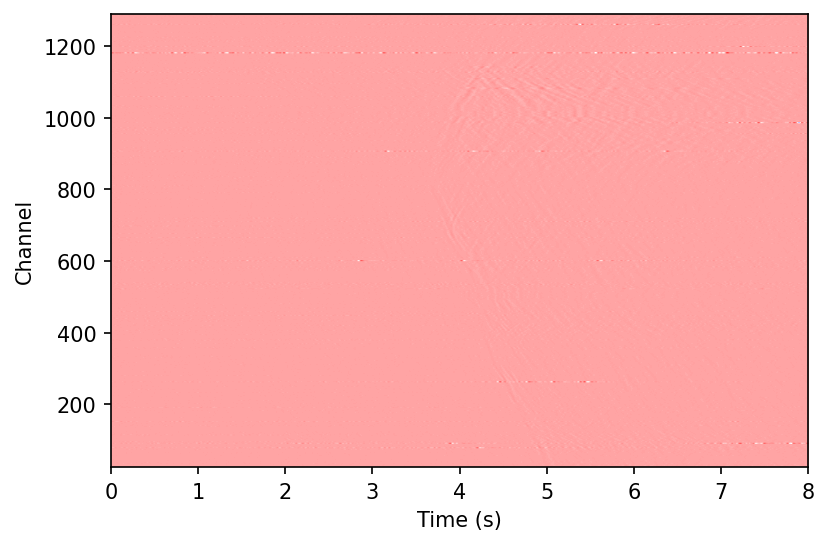

In [6]:
plot(data, t1-noise_window_len, t2, fs, startchannel, endchannel)

## clean data

We continue cleaning the data: based on its values in the time domain and characteristics in the frequency domain, we may replace some channels with the average of its neighbours.

In [7]:
data = clean_data(data, clean_amplitude, clean_threshold)

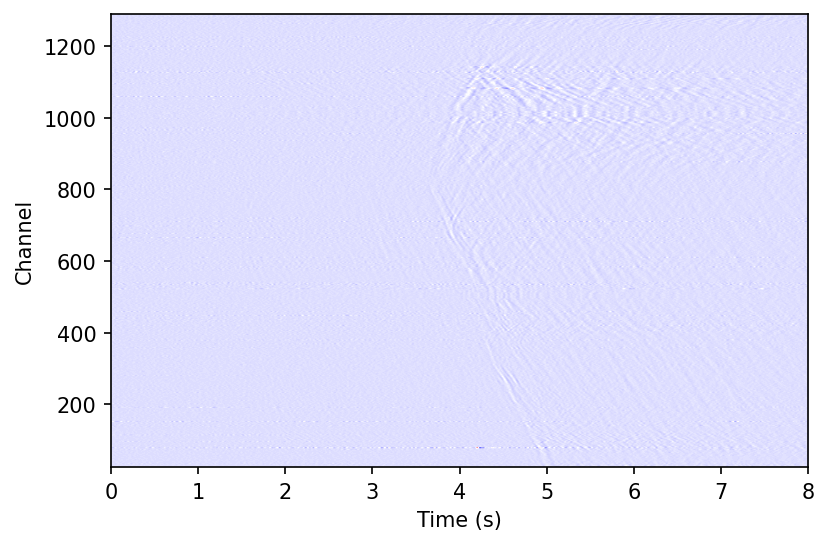

In [8]:
plot(data, t1-noise_window_len, t2, fs, startchannel, endchannel)

### Calculate SNR

Of each channel, we calculate the SNR, using the first two seconds of the data array as the noise window.

In [9]:
d = data.copy()

ps = np.zeros(len(d))
pn = np.zeros(len(d))

noise = d[:,0:int(noise_window_len*fs)].copy()
signal = d[:,int(noise_window_len*fs):].copy()


for i in range(len(d)):
    pn[i] = power(noise[i])
    ps[i] = power(signal[i])

pn[pn == 0] = 1
snr = ps/pn

### Correlate channels with good SNR

We correlate all channels with a SNR above a certain threshold.

In [10]:
idx_snr, jump = snr_channels(snr, snr_threshold1)

pick0, s0, id_good = correlate_channels(signal, idx_snr, interpolate_factor, minimum_velocity, startchannel, channel, fs, x, y, z)


### Interpolate in between channels with good SNR

In between the channels with high SNR values, we interpolate the travel time picks and uncertainty values.

We can now have a first look at the resulting arrival times. The times are relative, so they are plotted at the start of the array. In this first figure, we can see that the first arrival times seem to match the channels up to 800 reasonably well, but between channels 100 and 1100, the arrival times are in the wrong direction. This is due to the fact that we have to correlate the entire time series, and the later arrivals are much stronger in this event. 

The black/white colour of the arrival times correspond to the uncertainty of the picks.

In [11]:
pick, s = interpolate_channels(pick0, s0, idx_snr, id_good, len(signal), jump, interpolate_jump_fraction, jump_edge)


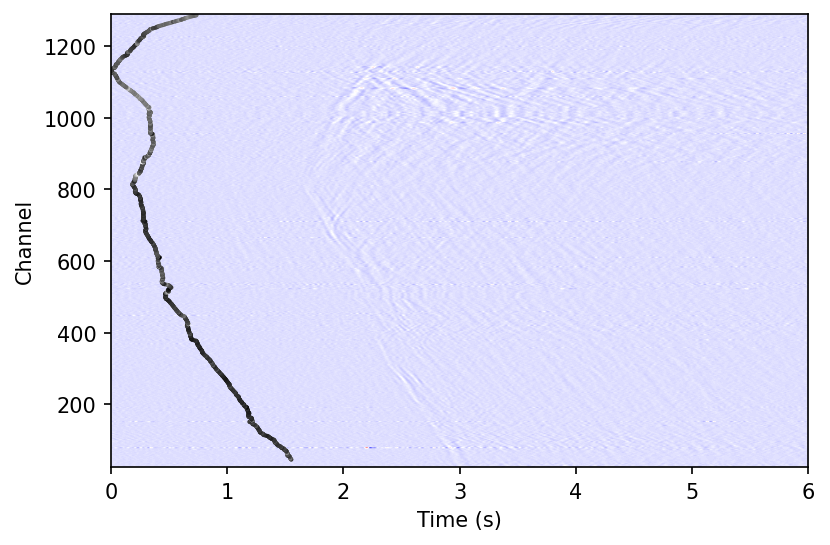

In [12]:
plot(signal, t1, t2, fs, startchannel, endchannel, picks=pick)

## Shift picks with respect to data

Now we 'shift' these picks over the data, and determine where they fit best. We bias this shift towards the earlier arrivals. 
This gives us absolute travel times. We can see more clearly where our first attempt succeeded/failed in estimating the first arrival times.

For many smaller events, this step is enough. For larger and more complicated events, we need to repeat this step with fewer data, to exclude the effects of later arrivals.

In [13]:
picks = correlate_2d(signal, pick, shift_threshold_fraction1)
shift_fit = fit_channels(signal, picks, s)

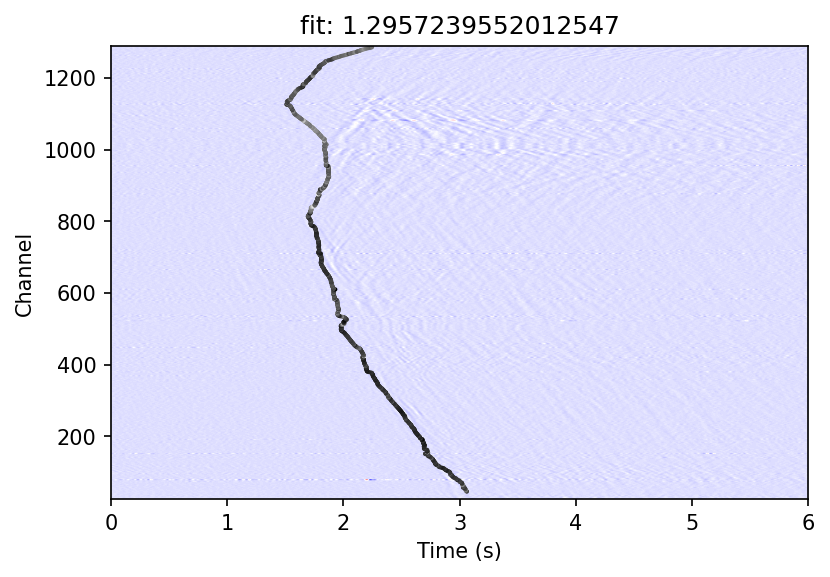

In [14]:
plot(signal, t1, t2, fs, startchannel, endchannel, picks=picks, shift_fit=shift_fit)

## Iterations with smaller windows

We repeat the steps above:
- correlate high SNR channels
- interpolate in between
- shift picks w.r.t. data

We do this with smaller and smaller time windows, that we define to be centered around the previously determined arrival times. We define a 'fit' of the arrival picks with the data, and use the result with the largest fit as the final result.

In [15]:
iterated_picks = []
iterated_picks.append(picks.copy())

fit = []
fit.append(shift_fit)

uncertainty = []
uncertainty.append(s)

no_nan = ~np.isnan(iterated_picks[-1])

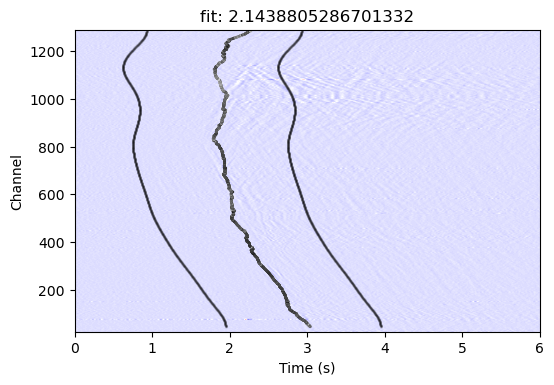

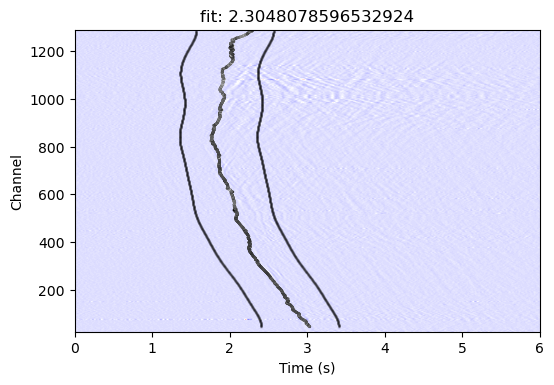

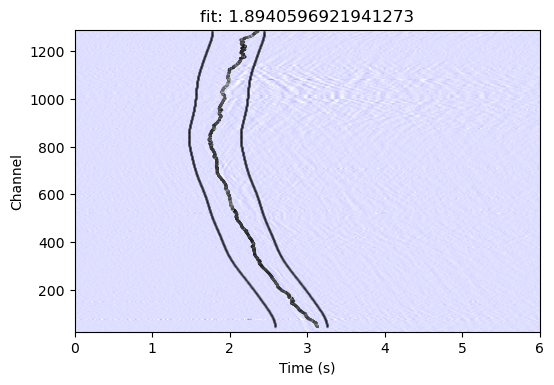

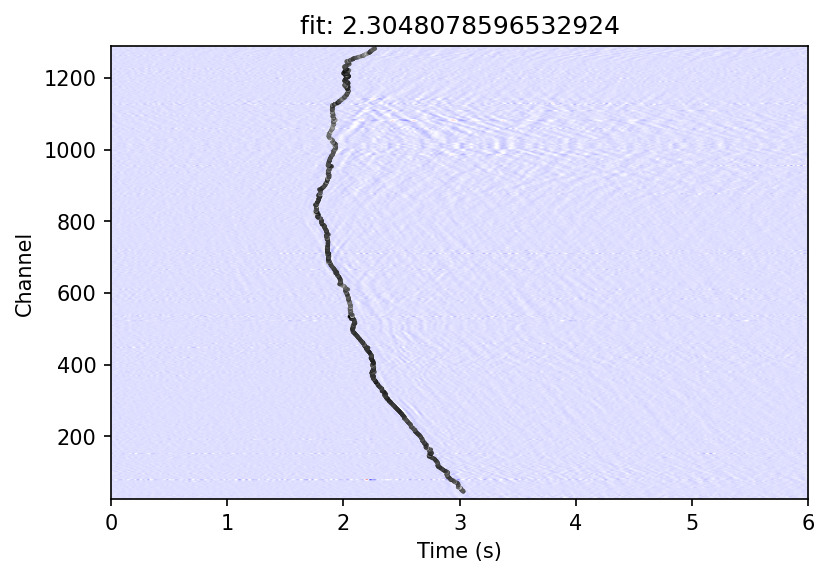

In [16]:
for it in range(iterations):
        
    ## define signal window
    
    window_len = int(signal.shape[1]/((it*decrease_window_product+decrease_window_sum)))
    while window_len%window_fraction != 0:
        window_len += 1
        
    
    ### define start and end windows around picks
    start_window, end_window = define_window(signal, iterated_picks[-1], window_len, window_fraction, window_smoothing)
    
    no_nan = ~np.isnan(iterated_picks[-1])
    
    ### create signal window
    signal_window = np.zeros(np.shape(signal))   
    for i in range(len(signal)):
        if no_nan[i]:
            signal_window[i, int(start_window[i]):int(end_window[i])] = signal[i, int(start_window[i]):int(end_window[i])]
   
    idx_snr, jump = snr_channels(snr, snr_threshold2)
    
    picks_cor, s0, id_good = correlate_channels(signal_window, idx_snr, interpolate_factor, minimum_velocity, startchannel, channel, fs, x, y, z, no_nan=no_nan)

    picks_interp, s = interpolate_channels(picks_cor, s0, idx_snr, id_good, len(signal), jump, interpolate_jump_fraction, jump_edge)
    
    picks_interp[~no_nan] = np.nan
    s[~no_nan] = np.nan
    if np.min(picks_interp[~np.isnan(picks_interp)]) > 0:
        picks_interp -= np.min(picks_interp[~np.isnan(picks_interp)])
    
        
    
    ### fit picks with data
    picks_shifted = correlate_2d(signal_window, picks_interp, shift_threshold_fraction2)

    
    shift_fit = fit_channels(signal_window, picks_shifted, s)
    
    iterated_picks.append(picks_shifted)
    fit.append(shift_fit)
    uncertainty.append(s)
    

    plot(signal, t1, t2, picks=iterated_picks[-1], shift_fit=shift_fit, start_window=start_window, end_window=end_window, dpi=100)


    
idx = np.argmax(fit)    

plot(signal, t1, t2, picks=iterated_picks[idx], shift_fit=fit[idx])